# CCRESS Training School - MUNICH 2025
### STRATfinder : an automated detection algorithm of the mixed layer height
#### NoteBook 1/2 : Signal Corrections
This code explores corrections that should be applied to attenuated backscatter observations observed with automatic lidars and ceiloeters (ALC). 

ALC continuously probe the atmosphere, operating 24/7, with a temporal resolution of seconds and a vertical resolution ranging from 5 to 15 meters depending on the instrument. 

Here, three ALC models are considered that are commonly deployed at ACTRIS NF: Lufft/Ott Hydromet CHM15k, Vaisala CL51, and Vaisala CL61.

INput files need to be processed with raw2l1 (M.-A. Drouin, SIRTA) - - before applying STRATFinder.

Once the raw signals are corrected, the STRATFinder algorithm (Kotthaus et al. 2020) - https://gitlab.in2p3.fr/ipsl/sirta/mld/stratfinder/stratfinder.git - can be applied to detect and track the mixed layer height (MLH).

#### M. Van Hove, IPSL & S. Kotthaus, Ecole Polytechnique 
#### Contact : mvanhove@ipsl.fr

In [1]:
#1
### ------- Import libraries ------- 

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import importlib

from datetime import date

import functions



In [2]:
#
### in case you edit the functions you need to reload them : 
importlib.reload(functions)
from functions import from_df_to_pivot, plot_overlap_corrections, plot_MLH
#import functions

In [3]:
#2
## -------- Path to data ----------- 

path_data = "/data/ACTRIS-CCRES/abl_heights"


In [4]:
#3
### --------- Input file : L1 -----------
# L1 Format : E-Profile => might be different from Actris L1 



### =========== CHM15k ============
# The CHM15k provide attenuated backscatter from around 100m to 15km => it has a near-range blind zone and an incomplete overlap zone which requires a correction  

# raw signal : L1 files 
raw_signal_chm_palaiseau = xr.open_mfdataset(f"{path_data}/eprofile_1a_LpalaiseauIchm15k_v01_20220704_000011_1440.nc").rcs_0.to_dataframe()
raw_signal_chm_payerne = xr.open_mfdataset(f"{path_data}/eprofile_1a_LpayerneIchm15k_v01_20220718_000011_1440.nc").rcs_0.to_dataframe()
raw_signal_chm_granada = xr.open_mfdataset(f"{path_data}/eprofile_1a_LgranadaIchm15k_v01_20220718_000011_1440.nc").rcs_0.to_dataframe()

# overlap correction
overlap_correction_palaiseau = xr.open_dataset(f"{path_data}/Hervo_overlapmodel_palaiseau_chm15k_B_TUB140013_15m.nc").to_dataframe()
overlap_correction_granada = xr.open_dataset(f"{path_data}/Hervo_overlapmodel_granada_chm15k_A_TUB170006_15m.nc").to_dataframe()
overlap_correction_payerne = xr.open_dataset(f"{path_data}/Hervo_overlapmodel_payerne_chm15k_A_TUB140016_15m.nc").to_dataframe()

# corrected & calibrated signal 
corrected_signal_chm_palaiseau = xr.open_mfdataset(f"{path_data}/eprofile_BSC_STRATFINDER_palaiseau_chm15k-B_v01_20220704.nc").beta.to_dataframe() 
corrected_signal_chm_payerne = xr.open_mfdataset(f"{path_data}/eprofile_BSC_STRATFINDER_payerne_chm15k-A_v01_20220718.nc").beta.to_dataframe()
corrected_signal_chm_granada = xr.open_mfdataset(f"{path_data}/eprofile_BSC_STRATFINDER_granada_chm15k-A_v01_20220718.nc").beta.to_dataframe()
corrected_signal_chm_paris = xr.open_dataset(f"{path_data}/eprofile_BSC_STRATFINDER_qualair_chm15k-A_v01_20220702.nc").beta.to_dataframe()
signal_2022_07_06_palaiseau = xr.open_mfdataset(f"{path_data}/eprofile_BSC_STRATFINDER_palaiseau_chm15k-B_v01_20220706.nc").beta.to_dataframe()

# Mixed layer height retrieved by STRATfinder (MLH)
MLH_raw_signal = xr.open_mfdataset(f"{path_data}/eprofile_1a_LpalaiseauIchm15k_v01_20220704_000011_1440_L2A_noov.nc").to_dataframe()
MLH_corrected_signal = xr.open_mfdataset(f"{path_data}/eprofile_L2B_STRATFINDER_palaiseau_chm15k-B_v01_20220704.nc").to_dataframe()
MLH_2022_07_06_palaiseau = xr.open_mfdataset(f"{path_data}/eprofile_L2B_STRATFINDER_palaiseau_chm15k-B_v01_20220706.nc").to_dataframe()
MLH_paris = xr.open_dataset(f"{path_data}/eprofile_1a_LqualairIchm15k_v01_20220702_000011_1440_L2A_140m.nc").to_dataframe()

In [5]:
#
### =========== CL61 ==============
# The CL61 provide attenuated backscatter from first gate to 15km => no correction is required  

# raw signal : L1 files
L1_CL61 =  xr.open_dataset(f"{path_data}/cl61_1a_HOTE_v01_20220702_000000_1440.nc").rcs_0.to_dataframe()

# Mixed layer height derived by STRATfinder (MLH)
MLH_CL61 = xr.open_dataset(f"{path_data}/cl61_1a_HOTE_v01_20220702_000000_1440_L2A_140.nc").to_dataframe()

In [6]:
#
### =========== CL51 ==============
# The CL51 provide attenuated backscatter from 1st gate to ~15km, however the signal becomes very noisy from ~7km onwards and an overestimation of the signal up to ~500m requires a correction 

# raw signal : L1 files
raw_signal_cl51 = xr.open_dataset(f"{path_data}/eprofile_1a_LkarlovIcl51_v01_20190604_000011_1440.nc").rcs_0.to_dataframe()

# correction
corr_cl51 = xr.open_mfdataset(f"{path_data}/cl51_correction_karlov.nc").to_dataframe()

# corrected signal 
corrected_signal_cl51 = xr.open_mfdataset(f"{path_data}/eprofile_L1B_CABAM_karlov_cl51-A_v01_20190604.nc").RBCS.to_dataframe()
corrected_signal_cl51 = corrected_signal_cl51.reorder_levels(["time", "station", "range"]).sort_index()

# Mixed layer height derived by STRATfinder (MLH)
MLH_raw_CL51 = xr.open_mfdataset(f"{path_data}/eprofile_1a_LkarlovIcl51_v01_20190604_000011_1440_L2A_nocorr_new.nc").to_dataframe()
MLH_corrected_CL51 = xr.open_mfdataset(f"{path_data}/eprofile_1a_LkarlovIcl51_v01_20190604_000011_1440_L2A.nc").to_dataframe()


## CHM15k

In [7]:
#4
### The CHM15k provide attenuated backscatter from around 15m to 15km. However, for most sensors, the lowest 200m only capture noise 
### (near-range blind zone) and data up to about 500m have to be corrected for the incomplete optical overlap (Hervo et al. 2016)

In [8]:
#5
### Make the data easier to handle and lighter

# uncorrected signal
pivot_raw_signal_chm_palaiseau = from_df_to_pivot(raw_signal_chm_palaiseau, 'rcs_0', 1) 
pivot_raw_signal_chm_payerne = from_df_to_pivot(raw_signal_chm_payerne, 'rcs_0', 1) 
pivot_raw_signal_chm_granada = from_df_to_pivot(raw_signal_chm_granada, 'rcs_0', 1) 

# corrected signal 
pivot_corrected_signal_chm_palaiseau = from_df_to_pivot(corrected_signal_chm_palaiseau, 'beta', 1)
pivot_corrected_signal_chm_payerne = from_df_to_pivot(corrected_signal_chm_payerne, 'beta', 1)
pivot_corrected_signal_chm_granada = from_df_to_pivot(corrected_signal_chm_granada, 'beta', 1)

# crop data
pivot_raw_signal_chm_palaiseau = pivot_raw_signal_chm_palaiseau.loc[:3000]
pivot_raw_signal_chm_payerne = pivot_raw_signal_chm_payerne.loc[:3000]
pivot_raw_signal_chm_granada = pivot_raw_signal_chm_granada.loc[:3000]

pivot_corrected_signal_chm_palaiseau = pivot_corrected_signal_chm_palaiseau.loc[:3000]
pivot_corrected_signal_chm_payerne = pivot_corrected_signal_chm_payerne.loc[:3000]
pivot_corrected_signal_chm_granada = pivot_corrected_signal_chm_granada.loc[:3000]

# MLH resampled
MLH_raw_signal = MLH_raw_signal.droplevel("station").MLH.resample("15min").mean()
MLH_corrected_signal = MLH_corrected_signal.droplevel("station_name").MLH.resample("15min").mean()

In [9]:
#6
### Example of the raw attenuated backscatter signal ready to be used for plot and analysis

pivot_raw_signal_chm_palaiseau

time,2022-07-04 00:00:00,2022-07-04 00:05:00,2022-07-04 00:10:00,2022-07-04 00:15:00,2022-07-04 00:20:00,2022-07-04 00:25:00,2022-07-04 00:30:00,2022-07-04 00:35:00,2022-07-04 00:40:00,2022-07-04 00:45:00,...,2022-07-04 23:10:00,2022-07-04 23:15:00,2022-07-04 23:20:00,2022-07-04 23:25:00,2022-07-04 23:30:00,2022-07-04 23:35:00,2022-07-04 23:40:00,2022-07-04 23:45:00,2022-07-04 23:50:00,2022-07-04 23:55:00
range,,,,,,,,,,,,,,,,,,,,,
14.985000,1.317940e+05,6.148489e+04,76544.921387,1.469607e+05,1.323633e+05,51204.255591,1.431978e+05,8.692442e+04,8.201627e+04,1.066082e+05,...,44240.485156,8.183685e+04,2.210079e+04,5.662605e+04,9.740726e+04,81904.055078,1.205311e+05,1.509889e+05,7.483536e+04,21543.151221
29.969999,-8.732629e+04,-6.302009e+04,166355.747925,2.103725e+05,1.882991e+05,235756.259961,4.413717e+05,5.005755e+05,1.205389e+05,6.761607e+04,...,5510.979688,4.130979e+05,3.009689e+05,9.436708e+04,3.507136e+05,176973.397070,2.149242e+05,7.016154e+04,-9.825184e+04,413810.504688
44.955002,2.648543e+05,2.640029e+05,264953.641016,1.627923e+05,1.363925e+06,768333.585938,1.553067e+05,7.665002e+05,6.291295e+05,5.683762e+03,...,480265.439093,-1.205754e+05,5.310297e+05,6.966755e+05,5.722428e+05,341354.907031,7.749494e+05,1.231227e+06,8.284457e+05,240277.474414
59.939999,8.822467e+05,2.108917e+06,845545.578906,1.088761e+06,4.799021e+05,827424.685352,8.813008e+05,-1.763137e+05,1.692631e+06,7.173123e+05,...,114269.195312,-3.437200e+05,1.327822e+06,1.103569e+06,-1.247401e+05,936815.553125,4.903199e+05,-7.301570e+05,-1.246533e+05,154848.703906
74.925003,2.028425e+06,2.503510e+05,30704.001563,7.647396e+05,2.666099e+06,553395.168750,1.300490e+06,2.265928e+06,3.971113e+05,2.212959e+06,...,264148.204688,2.721139e+06,1.693918e+06,1.432949e+06,3.371317e+06,735176.145312,1.244826e+06,8.921559e+05,1.862417e+06,397749.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937.060059,3.003512e+04,2.795175e+04,7081.746533,4.164166e+03,3.802178e+04,42741.037112,4.001215e+04,1.701424e+04,4.310901e+04,4.029507e+04,...,65824.456543,1.000227e+04,5.199684e+04,2.002292e+04,3.926553e+04,46770.937451,2.612931e+04,3.128872e+04,3.275590e+04,44562.802686
2952.044922,3.861069e+03,3.359854e+04,-4310.582544,2.414213e+04,6.118926e+04,38015.249509,3.093851e+04,8.816681e+03,1.606927e+04,2.141089e+04,...,21983.539587,6.099679e+03,1.223970e+04,1.797768e+04,4.003454e+03,35358.108301,2.759073e+04,4.534969e+04,3.451425e+04,53023.142090
2967.030029,2.403516e+04,1.548747e+04,7430.802948,4.092928e+04,2.237413e+04,33811.720114,-1.452992e+04,-1.148129e+04,9.484565e+03,3.160287e+04,...,33556.623950,6.519713e+03,4.184782e+03,2.743272e+04,8.248684e+03,39004.627173,1.415716e+04,3.221138e+04,2.678346e+04,50148.124496


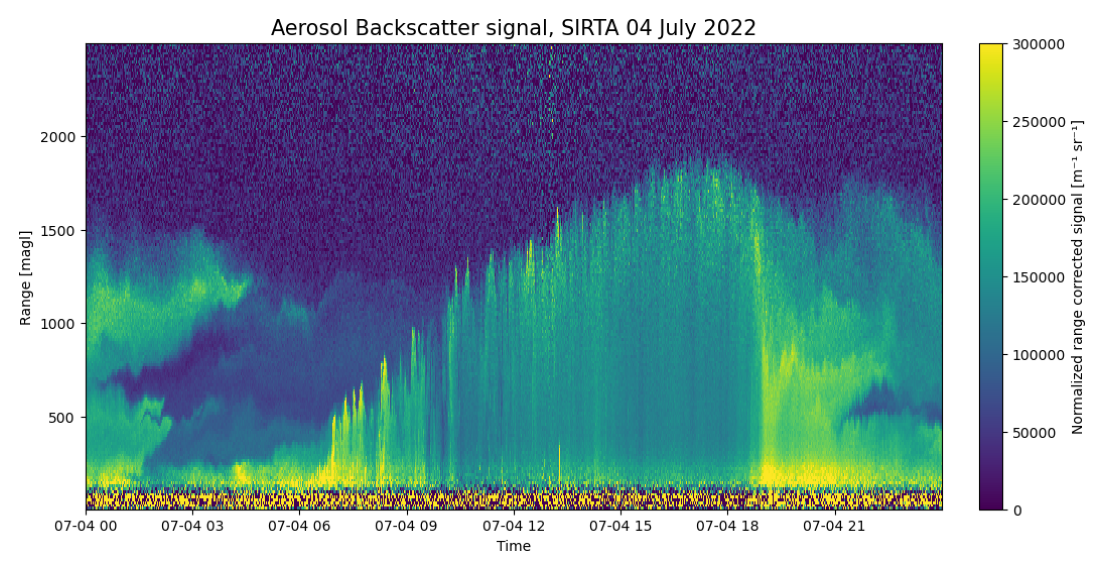

In [10]:
#7
### Figure of the raw attenuated backscatter signal 

plt.figure(figsize=(14, 9))

img = mpimg.imread(f"{path_data}/Raw_signal_SIRTA_CHM15k.png")

plt.imshow(img)
plt.axis("off") 
plt.show()

In [11]:
#
### Blind zone : no signal up to ~150m
### Overestimation of the signal from ~150m to ~250m
### !! colorbar label should be m2*counts/s

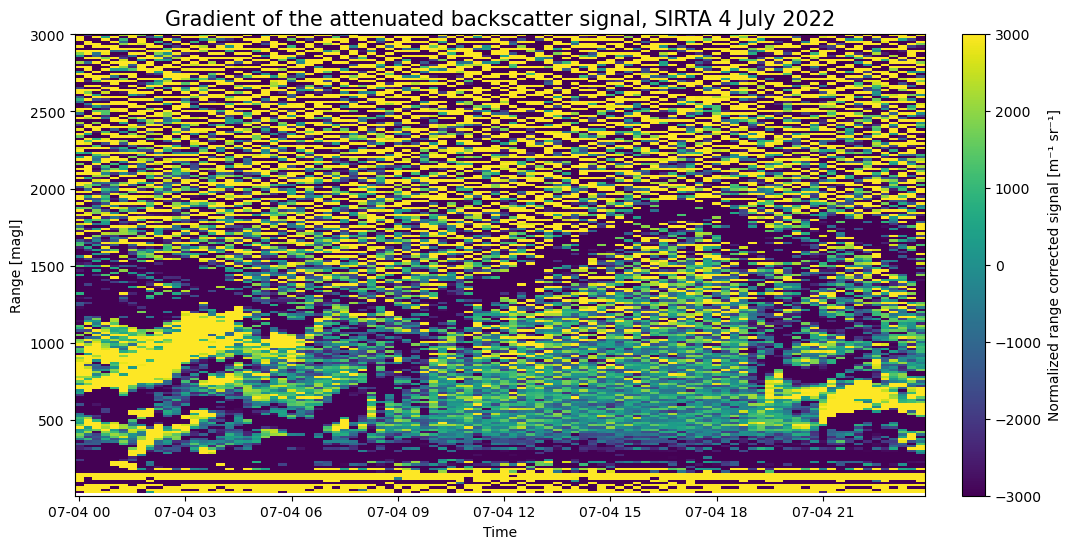

In [12]:
#
### Figure of the raw attenuated backscatter signal vertical gradient 

# The gradient is taken into account by the algorithm STRATfinder to track the MLH 
# The negative gradients are potential MLH as they are associated with sharp decreases of aerosols 

df = pivot_raw_signal_chm_palaiseau.T.resample("15min").mean().T.diff().copy()

fig, ax = plt.subplots(figsize=(12, 6))

img0 = ax.pcolormesh(
    df.columns,   
    df.index,     
    df.values,    
    vmin=-3 * 10**3,
    vmax=3 * 10**3,
    cmap="viridis",
)

# Titre et labels
ax.set_title("Gradient of the attenuated backscatter signal, SIRTA 4 July 2022", fontsize=15)
ax.set_xlabel("Time")
ax.set_ylabel("Range [magl]")

# Colorbar
cbar = fig.colorbar(img0, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Normalized range corrected signal [m⁻¹ sr⁻¹]")

In [13]:
#
### Areas of negative vertical gradients in attenuated backscatter indicate a decrease in aerosol content (and or humidity) and could hence mark a potential layer boundary. 
### Where negative gradients are consistent in space and time, this could be linked to e.g. the height of the mixed layer or the height of the residual layer.
### !!! colorbar label should be m2*counts/s

### CHM15k Overlap correction 

In [14]:
#
# CHM15k has incomplete overlap up to a height of about 700 m.
# Reference corrections functions are provided by manufacturer for each sensor. However, it does not capture the real variability 
# of the overlap function and is hence insufficient for a high-quality overlap correction.
# Recommended by ACTRIS : Temperature-dependant correction according to Hervo et al. (2016)
# Requirements : at least 1 year of data to derive the temperature-dependent overlap model
# Selection of clear-sky days : 1 correction per day (around 20% of days selected for 2 years in Payerne)
# For one range, considering all selected days, the correction shows a clear linear dependency of the temperature (quantified by the difference 
# between the corrected and uncorrected signal)
# In Hervo et al. 2016, the lowest temperatures (e.g. in winter) lead to a correction closer to the reference correction than when high temperatures are reached
# Final correction : linear fit coefficients a & b (a*Temp. + b) for each range  


In [15]:
#
# Overlap correction coefficients

overlap_correction_palaiseau

,a,b,overlap_ref
range,,,
14.985000,0.000000,0.000000,0.000020
29.969999,-0.799767,-29.566449,0.000030
44.955002,-0.377006,-67.651104,0.000040
59.939999,-0.220911,-81.350192,0.000053
74.925003,-0.114090,-89.164656,0.000081
...,...,...,...
15284.700195,0.000000,0.000000,1.000000
15299.684570,0.000000,0.000000,1.000000
15314.669922,0.000000,0.000000,1.000000


In [16]:
# Example : T = 20°, a = -0.1, b -10, overlap_ref = 0.00003
# deviation = (a*T + b)/100 = -0.12
# value = overlap_ref / (1 + deviation)  

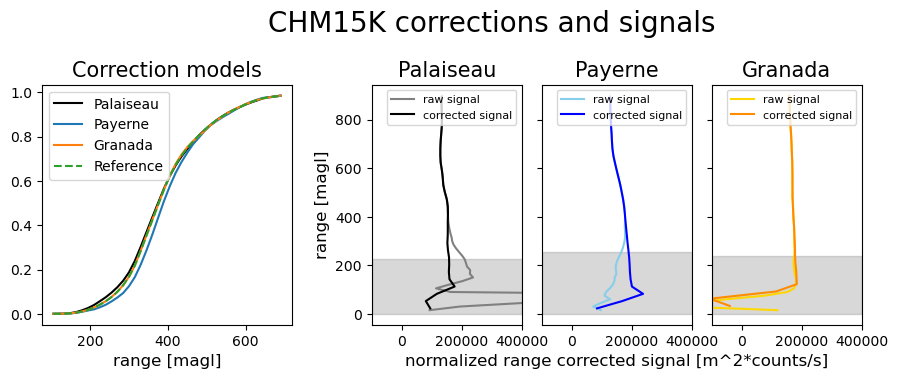

In [17]:
#
# Plot corrections

plot_overlap_corrections (overlap_correction_palaiseau, overlap_correction_payerne, overlap_correction_granada, 
                          pivot_raw_signal_chm_palaiseau, pivot_raw_signal_chm_payerne, pivot_raw_signal_chm_granada, 
                          pivot_corrected_signal_chm_palaiseau, pivot_corrected_signal_chm_payerne, pivot_corrected_signal_chm_granada)


### CHM15k Calibration

In [18]:
#
### Calibration & Plot time serie of CL

# To make the signals from different instruments comparable, a calibration step is required.
# This procedure relies on the selection of clear-sky conditions, typically during nighttime and in an altitude range around 5 km, 
# where the atmosphere is expected to contain only a very small amount of aerosols. 
# In such conditions, the signal can be considered close to the theoretical molecular (Rayleigh) backscatter profile, 
# which is well known and can therefore serve as a reference.

# For each clear-sky night, a calibration constant is derived. 
# The final calibration constant used for the instrument is defined as the median of all values obtained over multiple clear-sky nights. 
# It should be noted, however, that this approach is still under discussion, as a seasonal cycle has been observed in the calibration values.

# Once the calibration constant is determined, the attenuated backscatter signal can be calculated as:

# Attenuated backscatter signal = Backscatter signal / calibration constant 

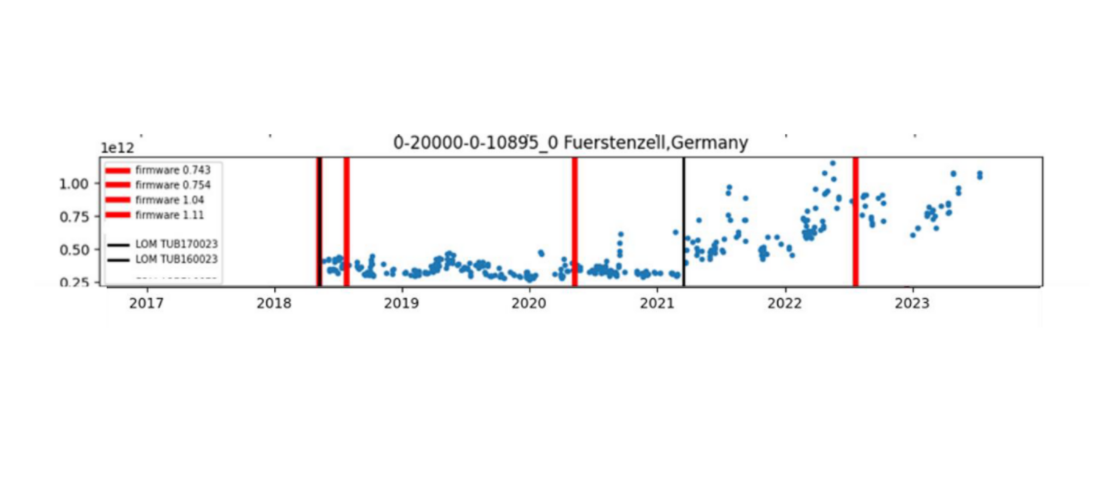

In [19]:
# Plot time serie of calibration constants at Fuerstenzell

plt.figure(figsize=(14, 9))

img = mpimg.imread(f"{path_data}/Calibration_constants.png")

plt.imshow(img)
plt.axis("off")  
plt.show()


In [20]:
# => Amplitude of calibration constants dependant of the laser optical module (LOM)
# => No impact of the firmware
# => visible seasonal cycle

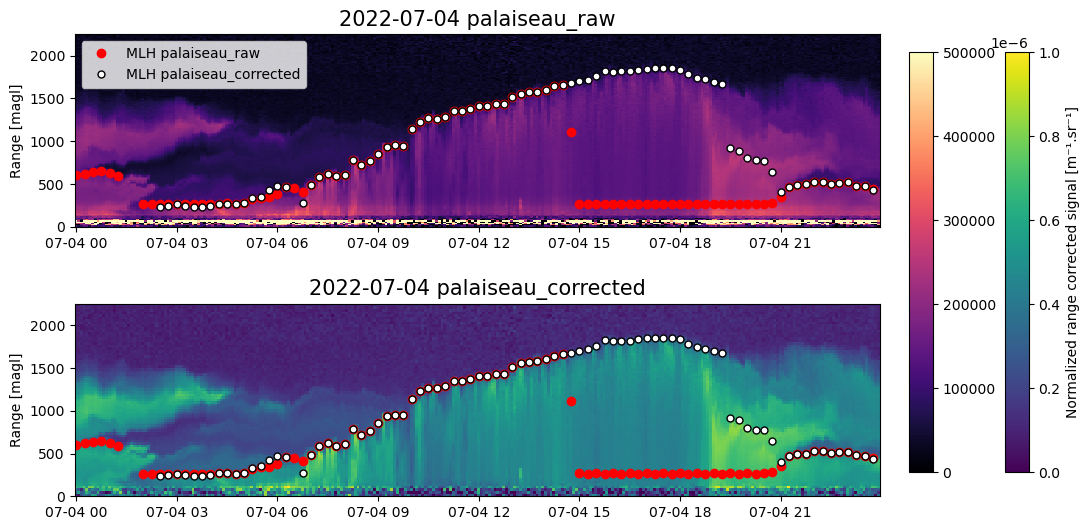

In [21]:
#
### Plot attenuated & corrected backscatter signal 

date_ = date(2022, 7, 4)
field1 = pivot_raw_signal_chm_palaiseau
field2 = pivot_corrected_signal_chm_palaiseau 
site1 = "palaiseau_raw"
site2 = "palaiseau_corrected"

data = {
    "MLH_palaiseau_raw": list(MLH_raw_signal),
    "MLH_palaiseau_corrected": list(MLH_corrected_signal),
}

df = pd.DataFrame(data, index = MLH_raw_signal.index)

vmin1 = 0
vmin2 = 0
vmax1 = 5 * 10**5
vmax2 = 1 * 10**-6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 0, "magma")

## CL61


In [22]:
# The Vaisala CL61 is a state-of-the-art ceilometer that provides continuous vertical profiling of the atmosphere up to 15 km 
# with a resolution of about 5m. Unlike traditional ceilometers, the CL61 includes depolarization measurements, 
# which enable the differentiation between liquid and solid particles, as well as the detection of specific aerosol types such as dust, 
# volcanic ash, or smoke. 
# In theory, the CL61 is designed to deliver calibrated measurements without requiring additional corrections; however, in practice, 
# some adjustments may still be necessary to ensure data consistency across different sites and conditions. 

In [23]:
#
MLH_CL61["MLH"]

time                           station
2022-07-02 00:00:40.624995840  1.0               NaN
2022-07-02 00:01:40.635996160  1.0               NaN
2022-07-02 00:02:40.672996864  1.0               NaN
2022-07-02 00:03:40.742003200  1.0               NaN
2022-07-02 00:04:40.520003328  1.0               NaN
                                             ...    
2022-07-02 23:55:40.654001664  1.0        357.600006
2022-07-02 23:56:40.436005120  1.0        328.799988
2022-07-02 23:57:40.643996672  1.0        300.000000
2022-07-02 23:58:40.511002368  1.0        271.200012
2022-07-02 23:59:40.587995136  1.0        242.399994
Name: MLH, Length: 1440, dtype: float32

In [24]:
#
### Make data easier to exploit and lighter

# CL61 Raw signal
pivot_L1_CL61 = from_df_to_pivot(L1_CL61, "rcs_0", 1)
pivot_L1_CL61 = pivot_L1_CL61.loc[:3000]

# CL61 Mixed Layer Height
#MLH_CL61 = MLH_CL61.droplevel("station_name")
#MLH_CL61 = MLH_CL61.droplevel("station")
MLH_CL61 = MLH_CL61.MLH.resample("15min").mean()

# CHM15k Paris
pivot_signal_paris = from_df_to_pivot(corrected_signal_chm_paris, "beta", 1)
pivot_signal_paris = pivot_signal_paris.loc[:3000]

# MLH Paris
#MLH_CHM15k = MLH_paris.droplevel("station_name")
MLH_CHM15k = MLH_paris.droplevel("station")
MLH_CHM15k = MLH_paris.MLH.resample("15min").mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'

In [ ]:
#
### Example of data from CL61 

pivot_L1_CL61

In [ ]:
#
date_ = date(2022, 7, 2)
field1 = pivot_signal_paris
field2 = pivot_L1_CL61
site1 = "CHM15K"
site2 = "CL61"

data = {
    #"MLH_CHM15K": list(MLH_paris.MLH),
    "MLH_CHM15K": list(MLH_CHM15k),
    #"MLH_CL61": list(MLH_CL61.MLH),
    "MLH_CL61": list(MLH_CL61)
}

df = pd.DataFrame(data, index = MLH_paris.index)

vmin1 = 0
vmin2 = 0
vmax1 = 1 * 10**-6
vmax2 = 1 * 10**-6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 0, "viridis")

In [ ]:
#
### Same figure but zoomed in at night

vmin1 = 0
vmax1 = 1 * 10**-6
vmin2 = 0
vmax2 = 1 * 10**-6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 0, 1, "viridis")
plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 1, "viridis")

## CL51
### Overlap correction

In [ ]:
#
### Make data easier to handle and analyse

# Raw & Corrected signal 
raw_signal_cl51 = from_df_to_pivot(raw_signal_cl51, "rcs_0", 1)
corrected_signal_cl51 = from_df_to_pivot(corrected_signal_cl51, "RBCS", 1)

raw_signal_cl51 = raw_signal_cl51.loc[:3000]
corrected_signal_cl51 = corrected_signal_cl51.loc[:3000]

# MLH
MLH_raw_CL51 = MLH_raw_CL51.reset_index(level=1,drop=True).MLH
MLH_corrected_CL51 = MLH_corrected_CL51.reset_index(level=1,drop=True).MLH
MLH_raw_CL51 = MLH_raw_CL51.resample("15min").mean()
MLH_corrected_CL51 = MLH_corrected_CL51.resample("15min").mean()


In [ ]:
#
# Example of data from a CL51

corrected_signal_cl51

In [ ]:
#
date_ = date(2019, 6, 4)
field1 = raw_signal_cl51
field2 = corrected_signal_cl51 
site1 = "CL51_raw_signal"
site2 = "CL51_corrected_signal"

data = {
    f"MLH_{site1}": list(MLH_raw_CL51),
    f"MLH_{site2}": list(MLH_corrected_CL51),
}

df = pd.DataFrame(data, index = MLH_raw_CL51.index)

vmin1 = 0
vmin2 = 0
vmax1 = 1 * 10**2
vmax2 = 1 * 10**6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 0, "magma")